1. Выбрать метод анализа и сравнить CTR в двух группах (мы разбирали t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования).
2. Сравните данные этими тестами. А еще посмотрите на распределения глазами. Почему тесты сработали так как сработали?
3. Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте.
4. Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.

Группа 1 - контрольная, 2 - группа с новым алгоритмом рекомендации постов

In [1]:
import numpy as np
import pandahouse
import seaborn as sns
from scipy.stats import ttest_ind, shapiro, mannwhitneyu, poisson

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20220620.feed_actions'}

In [3]:
q = '''
SELECT exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20220620.feed_actions
WHERE toDate(time) between '2022-05-25' and '2022-05-30'
    and exp_group in (1, 2)
GROUP BY exp_group, user_id
'''

In [4]:
df = pandahouse.read_clickhouse(q, connection=connection)

In [5]:
df.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,26,124,0.209677
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750


<AxesSubplot: xlabel='ctr', ylabel='Count'>

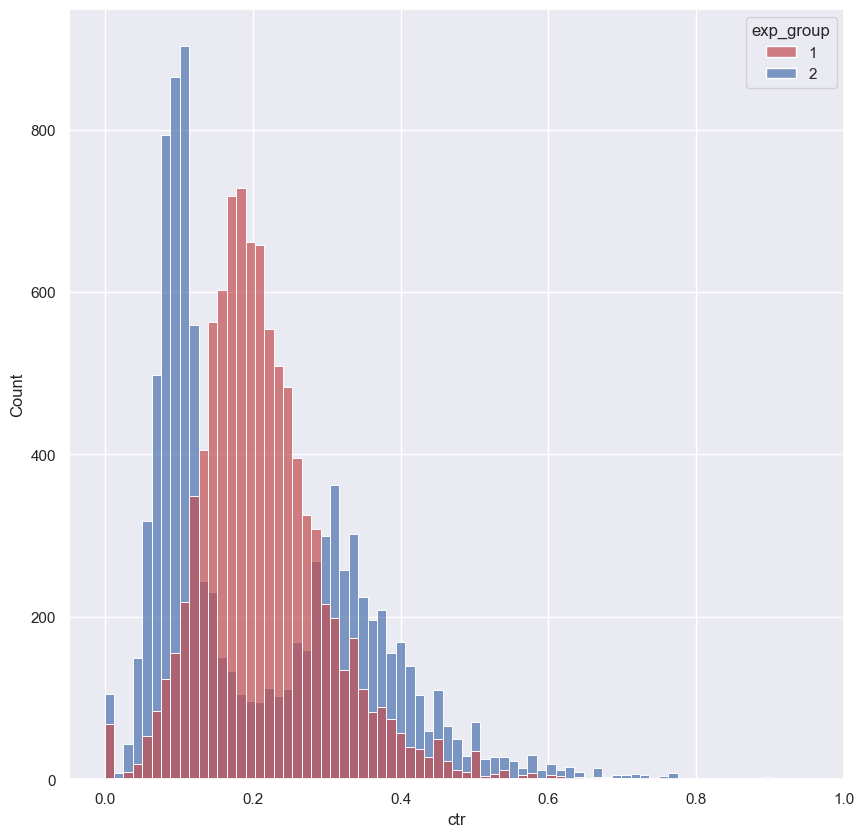

In [6]:
sns.set(rc={'figure.figsize': (10, 10)})

sns.histplot(data=df,
             x='ctr',
             hue='exp_group',
             alpha=0.7,
             palette=['r', 'b'])

Похоже на то, что поведение юзеров несколько отличается.

In [7]:
df.groupby('exp_group', as_index=False)\
    .agg(users=('user_id', 'nunique'),
         mean_ctr=('ctr', 'mean'))

,exp_group,users,mean_ctr
0,1,9420,0.214438
1,2,9299,0.212627


Возможно ли считать данные распределения нормальными?

In [8]:
group_a = df.query('exp_group == 1')
group_b = df.query('exp_group == 2')

In [9]:
shapiro(group_a.ctr)[1], shapiro(group_b.ctr)[1]

/Users/olegkarnugaev/.virtualenvs/standart_venv/lib/python3.10/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.0, 0.0)

Ни контрольное, ни тестовое распределение нельзя считать нормальным.
Однако предположим, что разница средних имеет нормальное распределение, а знаменатель в t-статистике описывает это распределение корректно.
Тогда

In [10]:
print(f't-test p value = {ttest_ind(group_a.ctr, group_b.ctr)[1]}')

t-test p value = 0.2947767710522671


Стат. значимых различий не обнаружено.
Но так как были приняты некоторые допущения, следует удостовериться в полученном результате доп. тестами.

In [11]:
print(f"Mannwhitneyu-test p value = {mannwhitneyu(group_a.ctr, group_b.ctr, alternative='two-sided')[1]}")

Mannwhitneyu-test p value = 3.5817498394864675e-50


Выявлены стат. значимые различия. Проверим расхождения иными тестами.

In [12]:
group_a_global_ctr = group_a.likes.sum() / group_a.views.sum()
group_b_global_ctr = group_b.likes.sum() / group_b.views.sum()

In [13]:
def get_smoothed_ctr(user_likes, user_views, global_ctr, alpha):
    smoothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smoothed_ctr

In [32]:
group_a.loc[:, 'smoothed_ctr'] = group_a.apply(lambda x: get_smoothed_ctr(x.likes, x.views, group_a_global_ctr, 5), axis=1)
group_b.loc[:, 'smoothed_ctr'] = group_b.apply(lambda x: get_smoothed_ctr(x.likes, x.views, group_b_global_ctr, 5), axis=1)

/var/folders/69/5q4hf9x56rb_wd5yv511rrt80000gn/T/ipykernel_47756/3844073241.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_a.loc[:, 'smoothed_ctr'] = group_a.apply(lambda x: get_smoothed_ctr(x.likes, x.views, group_a_global_ctr, 5), axis=1)
/var/folders/69/5q4hf9x56rb_wd5yv511rrt80000gn/T/ipykernel_47756/3844073241.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_b.loc[:, 'smoothed_ctr'] = group_b.apply(lambda x: get_smoothed_ctr(x.likes, x.views, group_b_global_ctr, 5), axis=1)


<AxesSubplot: xlabel='smoothed_ctr', ylabel='Count'>

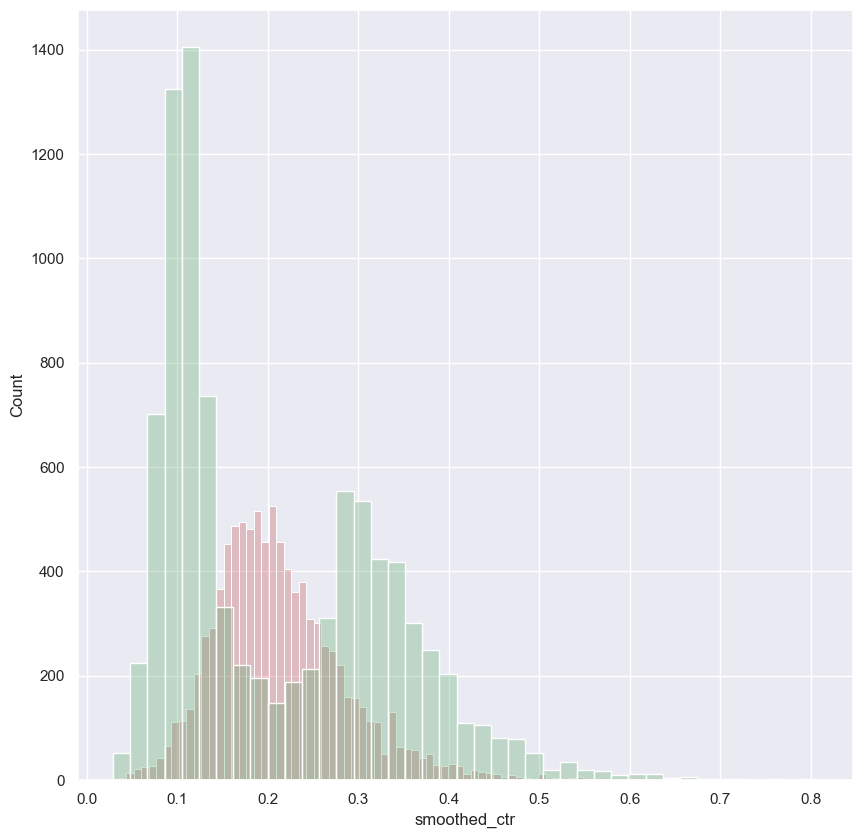

In [15]:
# Гистограмма распределенеий сглаженного ctr

sns.histplot(data=group_a,
             x='smoothed_ctr',
             alpha=0.3,
             color='r')

sns.histplot(data=group_b,
             x='smoothed_ctr',
             alpha=0.3,
             color='g')

Проведём t-тест на сглаженном ctr.

In [16]:
ttest_ind(group_a.smoothed_ctr,
          group_b.smoothed_ctr,
          equal_var=False)[1]

0.016239781024745055

Т-тест на сглаженном CTR показывает стат. значимые различия.
Проверим отличия с помощью бутстрепа.

In [17]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = poisson(1).rvs(
        (n_bootstrap, len(likes2))).astype(np.int64)

    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)

    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [18]:
likes_1 = group_a.likes.to_numpy()
likes_2 = group_b.likes.to_numpy()
views_1 = group_a.views.to_numpy()
views_2 = group_b.views.to_numpy()

In [19]:
ctr1, ctr2 = bootstrap(likes_1, views_1, likes_2, views_2)

<AxesSubplot: ylabel='Count'>

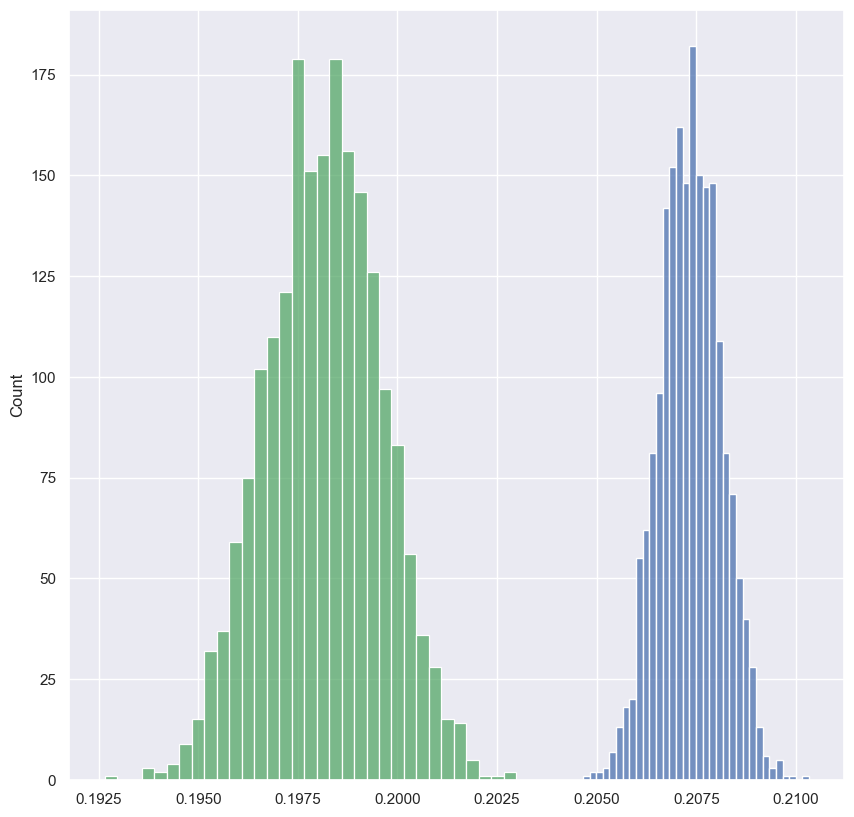

In [20]:
sns.histplot(ctr1, color='b')
sns.histplot(ctr2, color='g')

<AxesSubplot: ylabel='Count'>

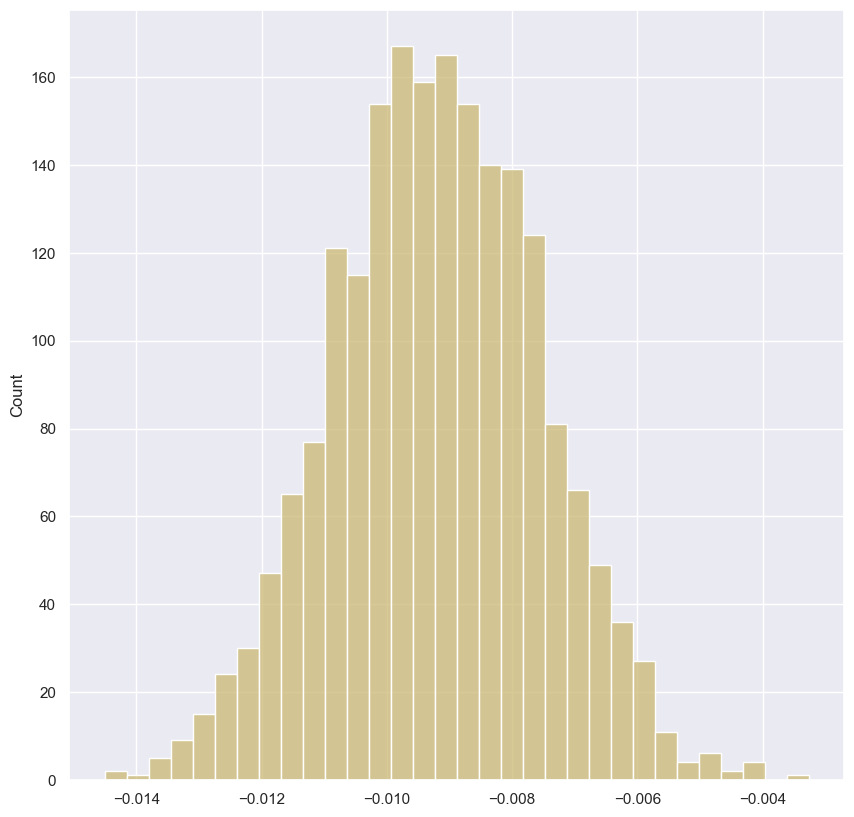

In [21]:
# разница между глобальными CTR

sns.histplot(ctr2 - ctr1, color='y')

Пуассоновский бутстреп также показал значимые различия.

In [22]:
q_bucket = '''

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr
FROM (SELECT exp_group,
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM simulator_20220620.feed_actions
    WHERE toDate(time) between '2022-05-25' and '2022-05-30'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
'''

In [23]:
bucket_df = pandahouse.read_clickhouse(q_bucket, connection=connection)

In [24]:
ttest_ind(bucket_df.query('exp_group == 1').bucket_ctr,
          bucket_df.query('exp_group == 2').bucket_ctr,
          equal_var = False)

Ttest_indResult(statistic=4.9945949832666985, pvalue=4.554930327719049e-06)

<AxesSubplot: xlabel='bucket_ctr', ylabel='Count'>

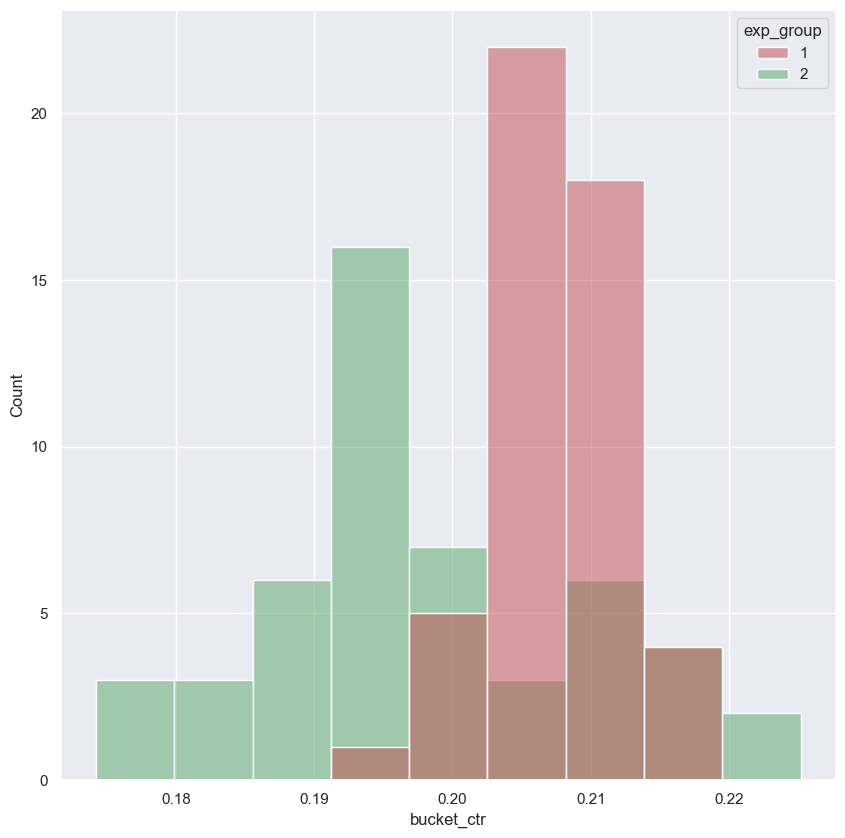

In [25]:
sns.histplot(data=bucket_df,
             x='bucket_ctr',
             hue='exp_group',
             palette=['r', 'g'],
             alpha=0.5)

Определённо есть стат. значимые различия между двумя группами.
Предполагаю, что отсутствие стат. значимых различий при использовании t-теста без каких-либо преобразований связано с тем, что CTR - метрика относительная и не учитывает абсолютных значений, т.е. пользователи с относительно маленьким кол-вом просмотров (несколько просмотров, например) могут повредить корректной оценке CTR.
При этом, если провести t-тест с определёнными преобразованиями (сглаженный CTR, бакетное преобразование), можно получить более адекватную, нечувствительную к такого рода пользователям оценку.

<AxesSubplot: xlabel='likes', ylabel='Count'>

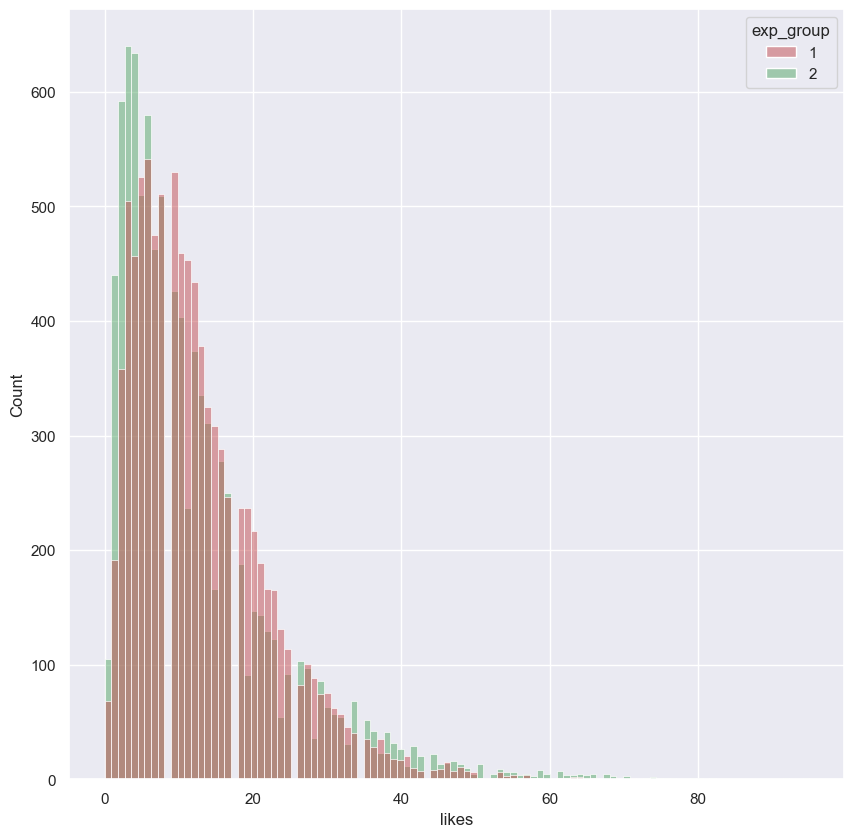

In [26]:
sns.histplot(df,
             x='likes',
             hue='exp_group',
             palette=['r', 'g'],
             alpha=0.5)

<AxesSubplot: xlabel='views', ylabel='Count'>

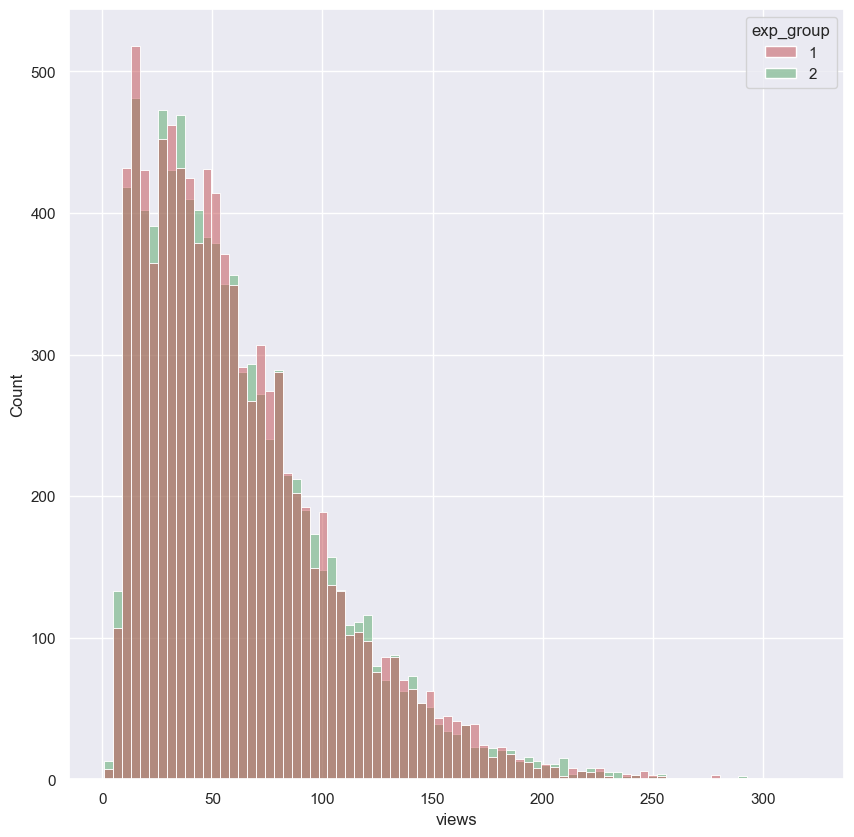

In [27]:
sns.histplot(df,
             x='views',
             hue='exp_group',
             palette=['r', 'g'],
             alpha=0.5)

In [28]:
group_a[['likes', 'views']].describe()

,likes,views
count,9420.000000,9420.000000
mean,12.825478,61.850318
std,9.247738,42.185799
min,0.000000,2.000000
25%,6.000000,30.000000
50%,11.000000,52.000000
75%,18.000000,84.000000
max,71.000000,300.000000


In [29]:
group_b[['likes', 'views']].describe()

,likes,views
count,9299.000000,9299.000000
mean,12.257877,61.864394
std,11.155338,42.476395
min,0.000000,1.000000
25%,4.000000,30.000000
50%,9.000000,52.000000
75%,16.000000,84.000000
max,95.000000,321.000000


**Итоги**

Поведение пользователей сильно похоже, однако бутстреп и бакетное образование + т-тест показывают, что в контрольной группе CTR несколько выше.
Также небольшие отличия видны на гистограмме распределения лайков по группам: в контрольной группе нет такого выраженного перекоса в нулевое кол-ва лайков.

Исходя из тестов предполагаю, что следует оставить контрольный вариант.